In [8]:
from qiskit import __version__
print(__version__)

1.4.2


In [14]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Operator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

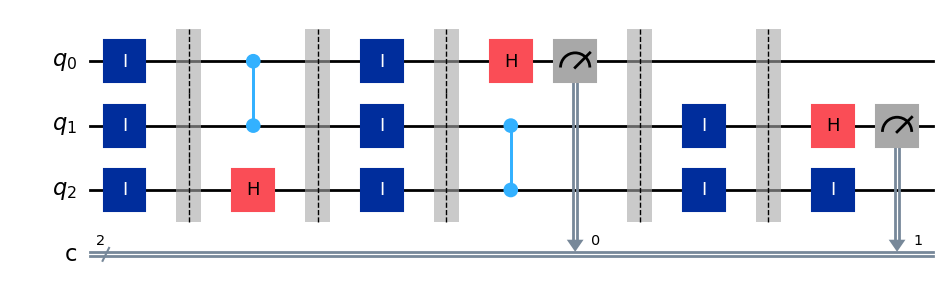

In [10]:
circuit = QuantumCircuit(3, 2)

# Insert errors right after state prep
for a in range(3):
    circuit.id(a)
circuit.barrier()

# CZ on qubits 0,1 and Hadamard on qubit 2
circuit.cz(0,1)
circuit.h(2)
circuit.barrier()

# Errors after the above gates
for j in range(3):
    circuit.id(j)
circuit.barrier()
    
# Measure qubit 0 in X basis, and CZ on qubits 1,2 
circuit.h(0)
circuit.measure(0,0)
circuit.cz(1,2)
circuit.barrier()

# Errors after above CZ gate
for j in range(1, 3):
    circuit.id(j)
circuit.barrier()

# Measure qubit 1 in X basis, and insert error on qubit 2
circuit.h(1)
circuit.measure(1,1)
circuit.id(2)

display(circuit.draw(output='mpl'))

# Results without Noise

Result(backend_name='aer_simulator_statevector', backend_version='0.14.2', qobj_id='', job_id='196eff88-d9ab-476a-9cb9-f7ca1c4734f7', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 264, '0x0': 250, '0x3': 288, '0x2': 198}), header=QobjExperimentHeader(creg_sizes=[['c', 2]], global_phase=0.0, memory_slots=2, n_qubits=3, name='circuit-165', qreg_sizes=[['q', 3]], metadata={}), status=DONE, seed_simulator=1472844390, metadata={'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 12, 'parallel_shots': 1, 'sample_measure_time': 0.00064901, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1, 2], 'device': 'CPU', 'time_taken': 0.001559017, 'measure_sampling': True, 'num_clbits': 2, 'max_memory_mb': 32768, 'input_qubit_map': [[2, 2], [1, 1], [0, 0]], 'num_qubits': 3, 'method': 'statevector', 'required_memory_mb': 1, 'fusion': {'enabled'

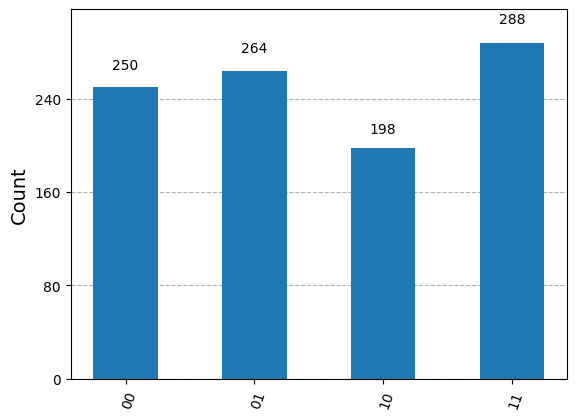

In [15]:
backend = AerSimulator(method='statevector')

job = backend.run(circuit,shots=1000)
result = job.result()
print(result)

counts = result.get_counts(circuit)
print(counts)
display(plot_histogram(counts)) 

# Results with Noise

Result(backend_name='aer_simulator_statevector', backend_version='0.14.2', qobj_id='', job_id='f6e0ba55-c171-410e-9782-eb12cf2d5dcf', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 246, '0x0': 273, '0x2': 242, '0x3': 239}), header=QobjExperimentHeader(creg_sizes=[['c', 2]], global_phase=0.0, memory_slots=2, n_qubits=3, name='circuit-165', qreg_sizes=[['q', 3]], metadata={}), status=DONE, seed_simulator=1833492260, metadata={'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 1, 'parallel_shots': 12, 'noise': 'circuit', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1, 2], 'device': 'CPU', 'time_taken': 0.025479522, 'measure_sampling': False, 'num_clbits': 2, 'max_memory_mb': 32768, 'input_qubit_map': [[2, 2], [1, 1], [0, 0]], 'num_qubits': 3, 'method': 'statevector', 'required_memory_mb': 1, 'fusion': {'applied': False, 'max_fused_qubits': 5, 

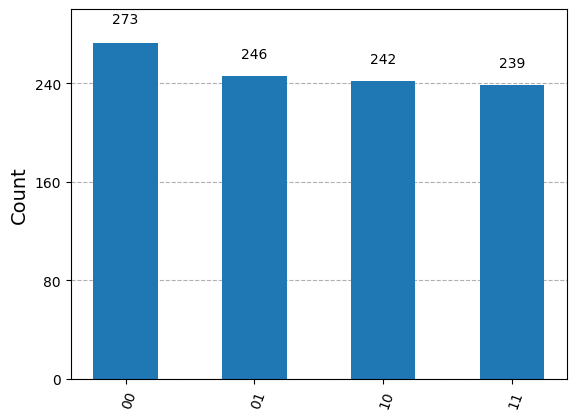

In [16]:
noise_model = NoiseModel()

noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['id'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,1), ['h'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01,2),['cz'])
# Measurement errors?

job = backend.run(circuit, noise_model=noise_model, shots=1000)
result = job.result()
print(result)

noisy_counts = result.get_counts(circuit)
print(noisy_counts)
display(plot_histogram(noisy_counts)) 